In [1]:
!wget -r -np -nH --cut-dirs=3 -R "index.html*" \
https://physionet.org/files/challenge-2016/1.0.0/training-a/

Streaming output truncated to the last 5000 lines.
Length: 104 [text/plain]
Saving to: ‘training-a/a0243.hea’

training-a/a0243.he 100%[===================>]     104  --.-KB/s    in 0s      

2025-04-30 09:28:20 (44.6 MB/s) - ‘training-a/a0243.hea’ saved [104/104]

--2025-04-30 09:28:20--  https://physionet.org/files/challenge-2016/1.0.0/training-a/a0243.wav
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 144938 (142K) [text/plain]
Saving to: ‘training-a/a0243.wav’

training-a/a0243.wa 100%[===================>] 141.54K   378KB/s    in 0.4s    

2025-04-30 09:28:20 (378 KB/s) - ‘training-a/a0243.wav’ saved [144938/144938]

--2025-04-30 09:28:20--  https://physionet.org/files/challenge-2016/1.0.0/training-a/a0244.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 142386 (139K) [application/octet-stream]
Saving to: ‘training-a/a0244.dat’

training-a/a0244.da 100%[===========

In [171]:
import pandas as pd
import librosa
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [172]:
#File Exploration
import os

# Path where the dataset is downloaded
dataset_path = '/content/training-a'

# List all the files in the directory
files = os.listdir(dataset_path)
files.sort()
print(files[:10])  # Show the first 10 files to confirm that we have the correct dataset


['MD5SUMS', 'RECORDS', 'RECORDS-abnormal', 'RECORDS-normal', 'REFERENCE-SQI.csv', 'REFERENCE.csv', 'SHA1SUMS', 'SHA256SUMS', 'a0001.dat', 'a0001.hea']


In [173]:
import pandas as pd
import os

# Set the path to the folder containing .wav files
wav_folder = '/content/training-a/'

# List all .wav files in the folder
wav_files = [file for file in os.listdir(wav_folder) if file.endswith('.wav')]
wav_files.sort()
wav_files[:30]

['a0001.wav',
 'a0002.wav',
 'a0003.wav',
 'a0004.wav',
 'a0005.wav',
 'a0006.wav',
 'a0007.wav',
 'a0008.wav',
 'a0009.wav',
 'a0010.wav',
 'a0011.wav',
 'a0012.wav',
 'a0013.wav',
 'a0014.wav',
 'a0015.wav',
 'a0016.wav',
 'a0017.wav',
 'a0018.wav',
 'a0019.wav',
 'a0020.wav',
 'a0021.wav',
 'a0022.wav',
 'a0023.wav',
 'a0024.wav',
 'a0025.wav',
 'a0026.wav',
 'a0027.wav',
 'a0028.wav',
 'a0029.wav',
 'a0030.wav']

Sample Rate: 22050
Audio Duration: 35.59650793650793 seconds


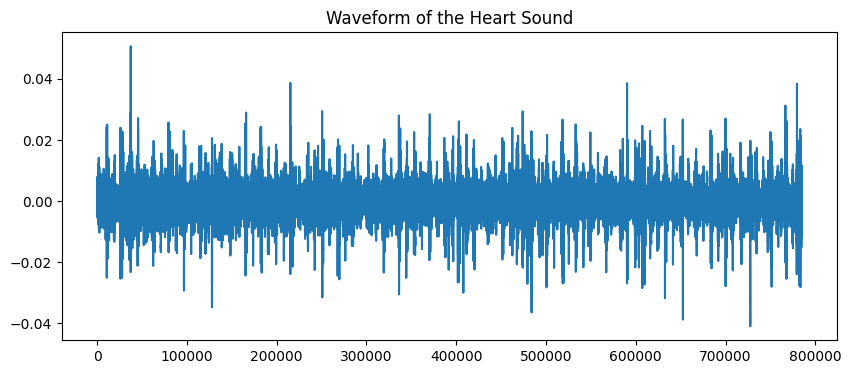

In [174]:
#Audio processing
import librosa
import matplotlib.pyplot as plt

# Load a .wav file
file_path = '/content/training-a/a0201.wav'
y, sr = librosa.load(file_path)

# Display some properties
print(f"Sample Rate: {sr}")
print(f"Audio Duration: {librosa.get_duration(y=y, sr=sr)} seconds")

# Plot the waveform of the audio
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.title("Waveform of the Heart Sound")
plt.show()

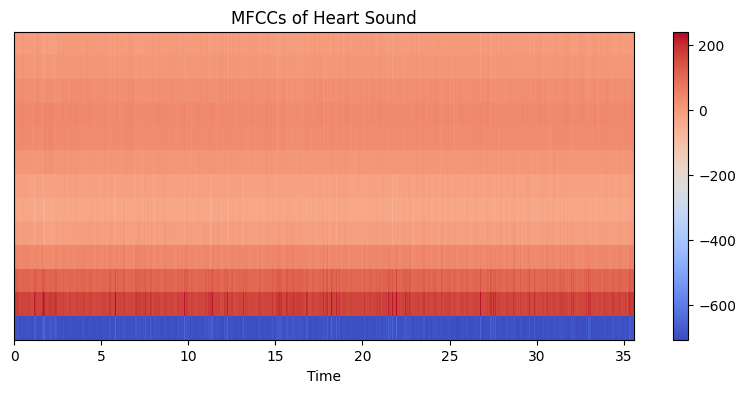

In [175]:
# Extract MFCCs from the audio
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCCs of Heart Sound")
plt.show()

In [176]:
# Load the REFERENCE.csv file with file_id and label
reference_csv_path = '/content/training-a/REFERENCE.csv'
reference_df = pd.read_csv(reference_csv_path, header=None, names=['file_id', 'label'], dtype={'file_id': str})

# Strip any extra spaces in the 'file_id' column
reference_df['file_id'] = reference_df['file_id'].str.strip()

# Match the .wav files with the file_id in the REFERENCE.csv
matched_files = [file for file in wav_files if file.replace('.wav', '') in reference_df['file_id'].values]

# Filter out the matching labels from the reference_df
matched_labels = reference_df[reference_df['file_id'].isin([file.replace('.wav', '') for file in matched_files])]

print(f"Matched Files: {matched_files[:10]}")  # Show a few matched files for inspection
print(f"Matched Labels: {matched_labels.head(10)}")  # Show the first few rows of matched labels


Matched Files: ['a0001.wav', 'a0002.wav', 'a0003.wav', 'a0004.wav', 'a0005.wav', 'a0006.wav', 'a0007.wav', 'a0008.wav', 'a0009.wav', 'a0010.wav']
Matched Labels:   file_id  label
0   a0001      1
1   a0002      1
2   a0003      1
3   a0004      1
4   a0005      1
5   a0006      1
6   a0007     -1
7   a0008      1
8   a0009     -1
9   a0010      1


In [141]:
# Replace all occurrences of -1 with 0 in the 'label' column
matched_labels['label'] = matched_labels['label'].replace(-1, 0)

# Verify the change
print(f"Updated Matched Labels: \n{matched_labels.head(10)}")


Updated Matched Labels: 
  file_id  label
0   a0001      1
1   a0002      1
2   a0003      1
3   a0004      1
4   a0005      1
5   a0006      1
6   a0007      0
7   a0008      1
8   a0009      0
9   a0010      1


In [142]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define a function to extract MFCC features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Load audio file
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract 13 MFCC features
    return np.mean(mfccs.T, axis=0)  # Return the mean of MFCCs across time frames

# Initialize lists for features and labels
features = []
labels = []

# Extract features for each matched file
for file in matched_files:
    # Construct the file path for each .wav file
    file_path = os.path.join(wav_folder, file)

    # Extract the features (MFCCs)
    file_features = extract_features(file_path)

    # Get the corresponding label from the reference dataframe
    file_id = file.replace('.wav', '')  # Strip '.wav' from filename to match file_id
    file_label = matched_labels[matched_labels['file_id'] == file_id]['label'].values[0]

    # Append the features and label to the lists
    features.append(file_features)
    labels.append(file_label)

# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Encode the labels (if necessary)
labels_encoded = LabelEncoder().fit_transform(labels)

# Print the shape of the feature matrix and labels array
print(f"Features Shape: {features.shape}")
print(f"Labels Shape: {labels_encoded.shape}")


Features Shape: (409, 13)
Labels Shape: (409,)


In [143]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Normalize the features
X_normalized = scaler.fit_transform(features)

print(f"Normalized Features Shape: {X_normalized.shape}")


Normalized Features Shape: (409, 13)


In [144]:
from sklearn.model_selection import train_test_split

# Split the normalized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, labels, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")


Training Features Shape: (327, 13)
Testing Features Shape: (82, 13)
Training Labels Shape: (327,)
Testing Labels Shape: (82,)


In [145]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

CNN-LSTM with Random Forest Classifier for Binary Classification

In [148]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
# Define Functional CNN + LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))

x = Conv1D(64, 3, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

x = Conv1D(128, 3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

x = LSTM(128, return_sequences=False)(x)
x = Dense(64, activation='relu', name='deep_features')(x)
x = Dropout(0.4)(x)

output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weights
)

# Evaluate base model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy (CNN+LSTM): {test_accuracy * 100:.2f}%")

# Extract features from 'deep_features' layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("deep_features").output)
X_train_features = feature_extractor.predict(X_train_reshaped)
X_test_features = feature_extractor.predict(X_test_reshaped)

# Scale features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

# Train Random Forest on deep features
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train_features_scaled, y_train)
y_pred_rf = rf.predict(X_test_features_scaled)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest on Deep Features Accuracy: {rf_accuracy * 100:.2f}%")


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.5795 - loss: 0.7000 - val_accuracy: 0.6220 - val_loss: 0.6915
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5312 - loss: 0.6834 - val_accuracy: 0.6463 - val_loss: 0.6915
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6088 - loss: 0.6828 - val_accuracy: 0.4878 - val_loss: 0.6922
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5962 - loss: 0.6868 - val_accuracy: 0.4390 - val_loss: 0.6927
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6013 - loss: 0.6774 - val_accuracy: 0.4634 - val_loss: 0.6932
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6524 - loss: 0.6729 - val_accuracy: 0.4512 - val_loss: 0.6942
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5878 - loss: 0.6535 - val_accuracy: 0.4268 - val_loss: 0.6948
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6247 - loss: 0.6286 - val_accuracy: 0.

CNN-LSTM with XGBoost for Binary Classification

In [149]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from xgboost import XGBClassifier
# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
# Define Functional CNN + LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))

x = Conv1D(64, 3, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

x = Conv1D(128, 3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

x = LSTM(128, return_sequences=False)(x)
x = Dense(64, activation='relu', name='deep_features')(x)
x = Dropout(0.4)(x)

output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weights  # useful if data is imbalanced
)

# Evaluate base model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy (CNN+LSTM): {test_accuracy * 100:.2f}%")

# Extract features from 'deep_features' layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("deep_features").output)
X_train_features = feature_extractor.predict(X_train_reshaped)
X_test_features = feature_extractor.predict(X_test_reshaped)

# Scale features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train_features, y_train)
y_pred_xgb = xgb.predict(X_test_features)

from sklearn.metrics import accuracy_score
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost on Deep Features Accuracy: {xgb_acc * 100:.2f}%")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4996 - loss: 0.6942 - val_accuracy: 0.5976 - val_loss: 0.6914
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5196 - loss: 0.6975 - val_accuracy: 0.6951 - val_loss: 0.6900
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5822 - loss: 0.6804 - val_accuracy: 0.6585 - val_loss: 0.6894
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5856 - loss: 0.6881 - val_accuracy: 0.5854 - val_loss: 0.6900
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5554 - loss: 0.6822 - val_accuracy: 0.5488 - val_loss: 0.6907
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5576 - loss: 0.6576 - val_accuracy: 0.4756 - val_loss: 0.6914
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6105 - loss: 0.6904 - val_accuracy: 0.4634 - val_loss: 0.6922
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6027 - loss: 0.6558 - val_accuracy: 0.

Stacked Ensemble Learning with CNN-LSTM for Binary Classification

In [150]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
# Define Functional CNN + LSTM model
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))

x = Conv1D(64, 3, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

x = Conv1D(128, 3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.3)(x)

x = LSTM(128, return_sequences=False)(x)
x = Dense(64, activation='relu', name='deep_features')(x)
x = Dropout(0.4)(x)

output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weights  # useful if data is imbalanced
)

# Evaluate base model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy (CNN+LSTM): {test_accuracy * 100:.2f}%")

# Extract features from 'deep_features' layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("deep_features").output)
X_train_features = feature_extractor.predict(X_train_reshaped)
X_test_features = feature_extractor.predict(X_test_reshaped)

# Scale features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42))
]

stacked = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked.fit(X_train_features, y_train)
y_pred_stack = stacked.predict(X_test_features)
stack_acc = accuracy_score(y_test, y_pred_stack)
print(f"Stacked Ensemble Accuracy: {stack_acc * 100:.2f}%")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5062 - loss: 0.7050 - val_accuracy: 0.6220 - val_loss: 0.6924
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5863 - loss: 0.6944 - val_accuracy: 0.6951 - val_loss: 0.6900
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5798 - loss: 0.6890 - val_accuracy: 0.7317 - val_loss: 0.6859
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6004 - loss: 0.6930 - val_accuracy: 0.7073 - val_loss: 0.6821
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5919 - loss: 0.6860 - val_accuracy: 0.7073 - val_loss: 0.6786
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6322 - loss: 0.6663 - val_accuracy: 0.7317 - val_loss: 0.6755
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5874 - loss: 0.6982 - val_accuracy: 0.7317 - val_loss: 0.6728
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6461 - loss: 0.6624 - val_accuracy: 0.

In [155]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Define Functional CNN + LSTM model with additional layers
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))

# Adding CNN layers
x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
# x = Conv1D(filters=256, kernel_size=3, activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPooling1D(pool_size=2)(x)
# x = Dropout(0.3)(x)

# Add LSTM layer with more units
x = LSTM(128, return_sequences=False)(x)

# Dense layer for classification
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weights  # useful if data is imbalanced
)

# Evaluate the base model
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy (CNN+LSTM): {test_accuracy * 100:.2f}%")

lstm_layer = model.layers[-4]  # The LSTM layer is usually the 4th from the end
feature_extractor = Model(inputs=model.input, outputs=lstm_layer.output)

# Predict the features from the train and test datasets
X_train_features = feature_extractor.predict(X_train_reshaped)
X_test_features = feature_extractor.predict(X_test_reshaped)

# Scale features
scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_test_features_scaled = scaler.transform(X_test_features)
# Stacking Classifier for ensemble
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42))
]

stacked = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacked.fit(X_train_features_scaled, y_train)

# Predict with the stacked model
y_pred_stack = stacked.predict(X_test_features_scaled)
stack_acc = accuracy_score(y_test, y_pred_stack)
print(f"Stacked Ensemble Accuracy: {stack_acc * 100:.2f}%")


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.4216 - loss: 0.6637 - val_accuracy: 0.7073 - val_loss: 0.6899
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4706 - loss: 0.7081 - val_accuracy: 0.7561 - val_loss: 0.6894
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5260 - loss: 0.6707 - val_accuracy: 0.6707 - val_loss: 0.6896
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4950 - loss: 0.6960 - val_accuracy: 0.6341 - val_loss: 0.6904
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4880 - loss: 0.6770 - val_accuracy: 0.5488 - val_loss: 0.6909
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5057 - loss: 0.6705 - val_accuracy: 0.5488 - val_loss: 0.6914
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5032 - loss: 0.6768 - val_accuracy: 0.4878 - val_loss: 0.6922
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5349 - loss: 0.6457 - val_accuracy: 0.

Stacked Ensemble Learning with CNN-LSTM (Bi-directional) for Binary Classification

In [157]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GlobalMaxPooling1D
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Define model
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))

# Enhanced CNN Block
x = Conv1D(128, kernel_size=5, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(256, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Bidirectional LSTM instead of vanilla LSTM
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)  # capture strongest signal

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train without early stopping to allow full learning
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test),
    class_weight=class_weights
)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy (CNN+BiLSTM): {test_accuracy * 100:.2f}%")

# Extract features from the last Dense layer (before output)
feature_extractor = Model(inputs=model.input, outputs=model.layers[-4].output)
X_train_features = feature_extractor.predict(X_train_reshaped)
X_test_features = feature_extractor.predict(X_test_reshaped)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

# Stronger stacking with tuned base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)),
    ('svc', SVC(probability=True, kernel='rbf', C=2)),
    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, eval_metric='logloss'))
]

stacked = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000))
stacked.fit(X_train_scaled, y_train)

y_pred_stack = stacked.predict(X_test_scaled)
stack_acc = accuracy_score(y_test, y_pred_stack)
print(f"Stacked Ensemble Accuracy: {stack_acc * 100:.2f}%")


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.4078 - loss: 0.7353 - val_accuracy: 0.2805 - val_loss: 0.6960
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4370 - loss: 0.7279 - val_accuracy: 0.3780 - val_loss: 0.6941
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4115 - loss: 0.7317 - val_accuracy: 0.5732 - val_loss: 0.6925
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5157 - loss: 0.7133 - val_accuracy: 0.6829 - val_loss: 0.6914
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5325 - loss: 0.7166 - val_accuracy: 0.7073 - val_loss: 0.6904
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5572 - loss: 0.6727 - val_accuracy: 0.6829 - val_loss: 0.6898
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6118 - loss: 0.6487 - val_accuracy: 0.6951 - val_loss: 0.6890
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5708 - loss: 0.6651 - val_accuracy: 0.6707 - val_loss

CNN-BiLSTM-Multihead Attention and Stacked Ensemble for Binary Classification

In [163]:
from keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


In [167]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [170]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GlobalMaxPooling1D
from keras.layers import MultiHeadAttention, LayerNormalization, Add
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Define input layer
input_layer = Input(shape=(X_train_reshaped.shape[1], 1))

# CNN layers (tweaked parameters)
x = Conv1D(256, 5, activation='relu', padding='same')(input_layer)  # Increase filters, added padding
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)  # Increased dropout rate for regularization

x = Conv1D(512, 3, activation='relu', padding='same')(x)  # Increased filters
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.4)(x)

# BiLSTM layers (tweaked parameters)
x = Bidirectional(LSTM(256, return_sequences=True))(x)  # Increased LSTM units
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Multi-Head Attention (tweaked parameters)
attn_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)  # Increased heads and key_dim
x = Add()([x, attn_output])  # Residual connection
x = LayerNormalization()(x)

# Global pooling and Dense layers
x = GlobalMaxPooling1D()(x)
x = Dense(256, activation='relu')(x)  # Increased number of neurons
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Build model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=150,
    batch_size=64,
    class_weight=class_weights,
    verbose=1
)

# Evaluate the base model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print(f"\nBase Model Accuracy: {test_acc * 100:.2f}%")

# Feature extraction
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
X_train_feat = feature_extractor.predict(X_train_reshaped)
X_test_feat = feature_extractor.predict(X_test_reshaped)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

# Stacked Ensemble (tweaked parameters)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=20, min_samples_split=4, random_state=42)),  # Increased n_estimators, max_depth
    ('svc', SVC(probability=True, kernel='rbf', C=1.5, gamma='scale')),  # Adjusted C and gamma
    ('xgb', XGBClassifier(n_estimators=300, learning_rate=0.01, max_depth=6, eval_metric='logloss'))  # Increased n_estimators, smaller learning_rate
]

# Stacked model
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000))
stack_model.fit(X_train_scaled, y_train)

# Evaluate stacked model
y_pred_stack = stack_model.predict(X_test_scaled)
stack_acc = accuracy_score(y_test, y_pred_stack)
print(f"Stacked Ensemble Accuracy: {stack_acc * 100:.2f}%")


Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 754ms/step - accuracy: 0.5960 - loss: 0.9078 - val_accuracy: 0.2805 - val_loss: 0.7555
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 576ms/step - accuracy: 0.5390 - loss: 0.7753 - val_accuracy: 0.2927 - val_loss: 0.7402
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 630ms/step - accuracy: 0.6090 - loss: 0.6573 - val_accuracy: 0.5244 - val_loss: 0.6936
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 766ms/step - accuracy: 0.5886 - loss: 0.6698 - val_accuracy: 0.6829 - val_loss: 0.6605
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - accuracy: 0.6221 - loss: 0.6797 - val_accuracy: 0.7195 - val_loss: 0.6337
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 486ms/step - accuracy: 0.6531 - loss: 0.6572 - val_accuracy: 0.7439 - val_loss: 0.6073
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - accuracy: 0.6626 - loss: 0.6319 - val_accuracy: 0.7317 - val_loss: 0.5929
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.5924 - loss: 0.7191 - val_accuracy: 0.7195 - 